# 📘 Практический конспект по машинному обучению

Автор: [Ваше имя]

Этот Jupyter Notebook — ваш **рабочий инструмент** для быстрого доступа к:
- Основным алгоритмам ML
- Метрикам качества
- Настройке гиперпараметров
- Сравнению моделей

Все примеры работают с `sklearn`, `xgboost`, `catboost`, `lightgbm`.

📌 **Цель**: иметь под рукой готовые шаблоны кода, которые можно копировать и адаптировать.

---

In [1]:
# === Установка библиотек (если нужно) ===
!pip install -q catboost lightgbm xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === Импорты ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    KFold, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
plt.style.use('seaborn-v0_8')

## 📥 Данные

Используем:
- `diabetes` — для задачи **регрессии** (прогрессирование диабета)
- `breast_cancer` — для **классификации** (доброкачественный/злокачественный)

Разделение: 80% обучение, 20% тест. Фиксируем `random_state=42` для воспроизводимости.

In [3]:
# Загрузка данных
diabetes = load_diabetes()
X_reg, y_reg = diabetes.data, diabetes.target

cancer = load_breast_cancer()
X_cls, y_cls = cancer.data, cancer.target

# Разделение
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

## 🧠 Основные алгоритмы машинного обучения

Кратко о каждом алгоритме: математика, ключевые параметры, когда использовать.

### 1. Линейная регрессия

**Математика**: $ y = w_0 + w_1 x_1 + \dots + w_n x_n $. Коэффициенты находятся методом наименьших квадратов.

**Параметры**:
- Нет гиперпараметров (в базовой версии)
- Чувствителен к масштабу

**Когда использовать**: Когда зависимость линейная, данные чистые, нужна интерпретируемость.

In [4]:
model = LinearRegression()
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.453


### 2. Логистическая регрессия

**Математика**: $ P(y=1) = \frac{1}{1 + e^{-(w_0 + w_1 x_1 + \dots)}} $. Оптимизирует лог. правдоподобие.

**Параметры**:
- `C` — сила регуляризации (меньше = сильнее)
- `penalty` — 'l1', 'l2', 'elasticnet'

**Когда использовать**: Для бинарной классификации, когда нужны вероятности и интерпретация.

In [5]:
model = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=42)
model.fit(X_train_cls, y_train_cls)
y_pred = model.predict(X_test_cls)

print("Accuracy:", round(accuracy_score(y_test_cls, y_pred), 3))

Accuracy: 0.956


c:\Users\maksi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3. Decision Tree

**Математика**: Рекурсивно делит данные по признакам, минимизируя неоднородность (MSE для регрессии).

**Параметры**:
- `max_depth` — глубина дерева
- `min_samples_split` — минимум объектов для разбиения
- `min_samples_leaf` — минимум в листе

**Когда использовать**: Когда нужна интерпретируемость, есть нелинейности, выбросы.

In [6]:
model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.352


### 4. Random Forest

**Математика**: Ансамбль деревьев, обученных на случайных подвыборках. Итог — усреднение.

**Параметры**:
- `n_estimators` — число деревьев
- `max_features` — сколько признаков учитывать при разбиении

**Когда использовать**: Универсальный алгоритм, хорошо работает «из коробки».

In [7]:
model = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.445


### 5. Gradient Boosting (sklearn)

**Математика**: Деревья строятся последовательно, каждое исправляет ошибки предыдущего.

**Параметры**:
- `n_estimators`
- `learning_rate`
- `max_depth`

**Когда использовать**: Когда нужна высокая точность и можно потратить время на настройку.

In [8]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.453


### 6. XGBoost

**Особенности**: Быстрый, регуляризованный, поддерживает параллелизм.

**Параметры**:
- `reg_alpha`, `reg_lambda` — L1/L2 регуляризация
- `subsample`, `colsample_bytree` — доля данных и признаков

**Когда использовать**: Когда нужна максимальная точность и скорость.

In [9]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.441


### 7. CatBoost

**Особенности**: Устойчив к категориальным признакам, не требует предобработки.

**Параметры**:
- `iterations` — число деревьев
- `l2_leaf_reg` — аналог регуляризации

**Когда использовать**: Если есть категориальные признаки или нужно меньше предобработки.

In [10]:
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0, random_state=42)
model.fit(X_train_reg, y_train_reg, verbose=False)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.488


### 8. LightGBM

**Особенности**: Очень быстро, использует leaf-wise рост деревьев.

**Параметры**:
- `num_leaves` — число листьев (важнее, чем `max_depth`)
- `min_data_in_leaf` — устойчивость к шуму

**Когда использовать**: Когда важна скорость и работа с большими данными.

In [11]:
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 353, number of used features: 10
[LightGBM] [Info] Start training from score 153.736544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\maksi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 9. SVM

**Математика**: Находит разделяющую гиперплоскость с максимальным зазором.

**Параметры**:
- `C` — штраф за нарушение зазора
- `gamma` — масштаб ядра (RBF)

**Когда использовать**: Когда данные хорошо разделимы, или нужно ядро для нелинейности.

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

model = SVR(C=1.0, kernel='rbf', gamma='scale')
model.fit(X_train_scaled, y_train_reg)
y_pred = model.predict(X_test_scaled)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.182


### 10. k-NN

**Математика**: Предсказывает по среднему k ближайших соседей.

**Параметры**:
- `n_neighbors` — число соседей
- `weights` — 'uniform' или 'distance'

**Когда использовать**: Когда данные локально гладкие, и размер выборки невелик.

In [13]:
model = KNeighborsRegressor(n_neighbors=5, weights='uniform')
model.fit(X_train_scaled, y_train_reg)
y_pred = model.predict(X_test_scaled)

print("R²:", round(r2_score(y_test_reg, y_pred), 3))

R²: 0.425


## 📊 Сравнение моделей

Сравним 5 моделей на задаче регрессии. Все обучены на одинаковом разбиении.

In [14]:
models = {
    "Linear": LinearRegression(),
    "RF": RandomForestRegressor(n_estimators=100, random_state=42),
    "GB": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGB": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    r2 = round(r2_score(y_test_reg, y_pred), 3)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    results[name] = {"R²": r2, "RMSE": round(rmse, 2)}

# Вывод таблицы
print(f"{'Модель':<8} {'R²':<7} {'RMSE':<7}")
print("-" * 25)
for name, metrics in results.items():
    print(f"{name:<8} {metrics['R²']:<7} {metrics['RMSE']:<7}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 353, number of used features: 10
[LightGBM] [Info] Start training from score 153.736544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\maksi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 📈 Визуализация результатов

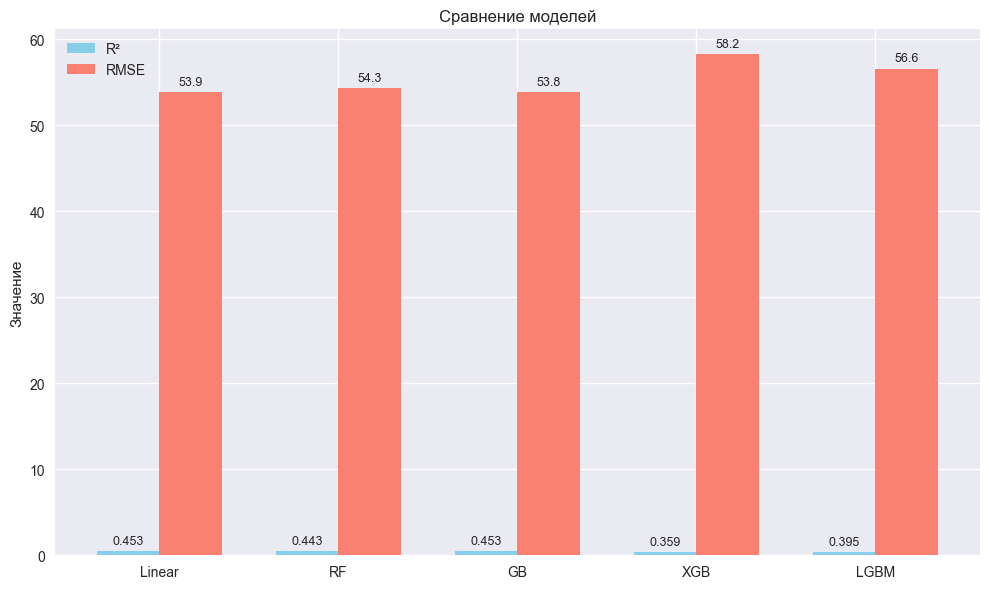

In [15]:
names = list(results.keys())
r2_scores = [results[name]['R²'] for name in names]
rmse_scores = [results[name]['RMSE'] for name in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²', color='skyblue')
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE', color='salmon')

ax.set_ylabel('Значение')
ax.set_title('Сравнение моделей')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 📌 Где и когда использовать каждую модель?

| Модель | Когда использовать |
|-------|-------------------|
| **Линейная регрессия** | Простота, интерпретация, линейные зависимости |
| **Логистическая регрессия** | Бинарная классификация, вероятности, интерпретация |
| **Decision Tree** | Интерпретация, нелинейности, выбросы |
| **Random Forest** | Универсальный алгоритм, устойчив к переобучению |
| **Gradient Boosting** | Высокая точность, время на настройку |
| **XGBoost** | Максимальная точность, скорость, стабильность |
| **CatBoost** | Есть категориальные признаки, мало предобработки |
| **LightGBM** | Большие данные, высокая скорость |
| **SVM** | Хорошо разделимые данные, нелинейности через ядро |
| **k-NN** | Локальные зависимости, малые выборки |

✅ **Совет**: Начинайте с `Random Forest` или `XGBoost` — они редко подводят.

## 🧰 Оптимизация гиперпараметров

Примеры `GridSearchCV`, `RandomizedSearchCV`, `Early Stopping`.

In [16]:
# GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_reg, y_train_reg)
print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [17]:
# RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2)
}

random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42), param_dist, n_iter=20, cv=3, scoring='r2', n_jobs=-1, random_state=42
)
random_search.fit(X_train_reg, y_train_reg)
print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'learning_rate': np.float64(0.14606150771755597), 'max_depth': 3, 'n_estimators': 67}


In [25]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    early_stopping_rounds=10  
)

# eval_set передаётся в fit(), как обычно
model.fit(
    X_train_reg, y_train_reg,
    eval_set=[(X_test_reg, y_test_reg)],
    verbose=False
)

print("Оптимальное число деревьев:", model.best_iteration)

Оптимальное число деревьев: 33
